<a href="https://colab.research.google.com/github/econ105/AI/blob/main/explainableAIforhousingpriceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

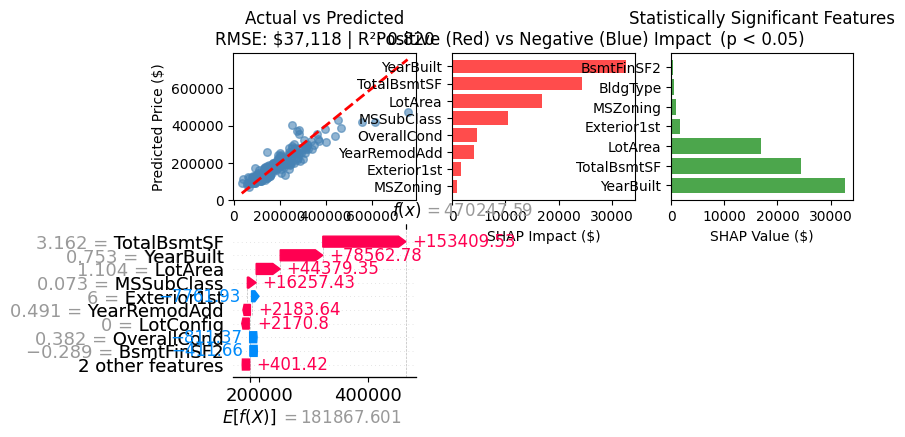

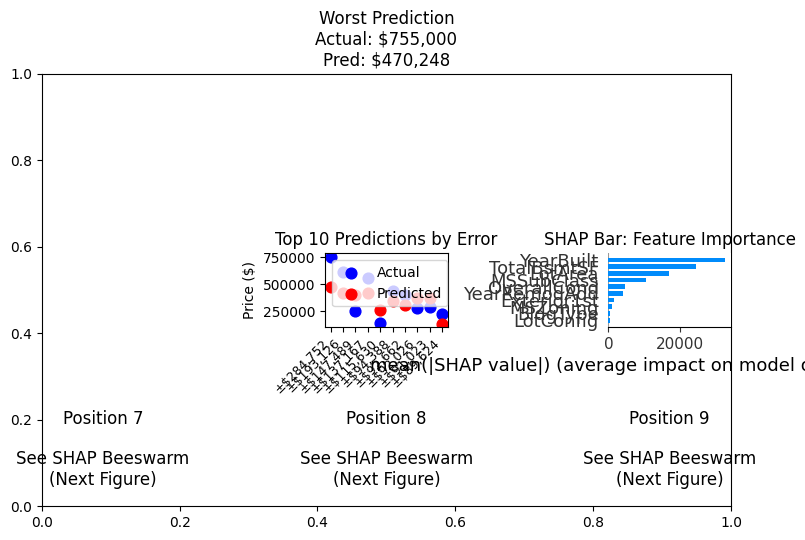

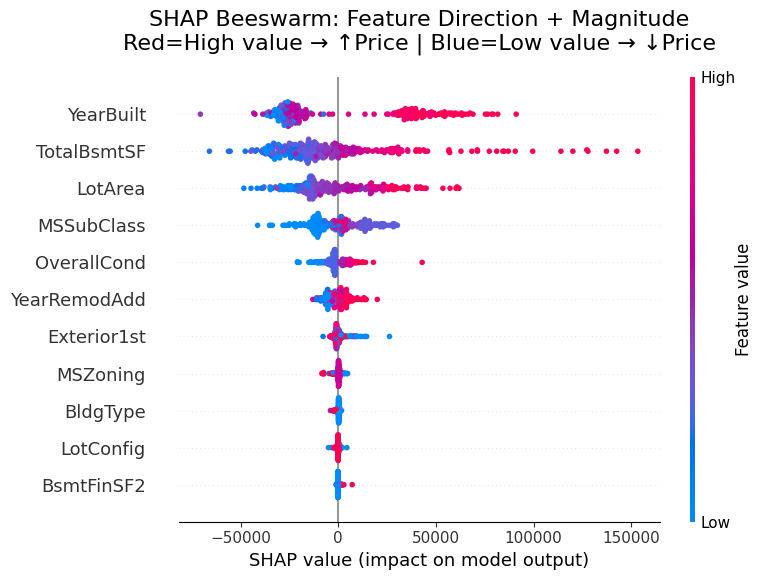

🏠 HOUSE PRICE PREDICTION - SHAP EXPLAINABLE AI ANALYSIS
Model Performance: RMSE=$37,118 | R²=0.820

📊 TOP 10 FEATURE IMPACT & STATISTICAL SIGNIFICANCE:
     feature  mean_shap  positive_impact  negative_impact  p_value  significant
   YearBuilt    32685.0           9530.0           8280.0      0.0         True
 TotalBsmtSF    24503.0           9530.0           8280.0      0.0         True
     LotArea    16886.0           9530.0           8280.0      0.0         True
  MSSubClass    10514.0           9530.0           8280.0      0.0        False
 OverallCond     4613.0           9530.0           8280.0      0.0        False
YearRemodAdd     4124.0           9530.0           8280.0      0.0        False
 Exterior1st     1705.0           9530.0           8280.0      0.0         True
    MSZoning      909.0           9530.0           8280.0      0.0         True
    BldgType      522.0           9530.0           8280.0      0.0         True
   LotConfig      383.0           9530.0        

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import shap
from scipy import stats

# Load and preprocess data
df = pd.read_excel('HousePricePrediction.xlsx', sheet_name='Sheet1')
df = df.dropna(subset=['SalePrice']).drop('Id', axis=1)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipeline
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
y_pred = model.predict(X_test)
residuals = y_test.values - y_pred

# SHAP statistical summary
shap_summary = pd.DataFrame({
    'feature': X.columns,
    'mean_shap': np.mean(np.abs(shap_values), axis=0),
    'positive_impact': np.mean(shap_values[shap_values > 0]),
    'negative_impact': np.mean(np.abs(shap_values[shap_values < 0])),
    'p_value': np.zeros(len(X.columns))
})

for i, feature in enumerate(X.columns):
    feature_shap = shap_values[:, i]
    shap_summary.loc[i, 'p_value'] = stats.wilcoxon(feature_shap).pvalue

shap_summary['significant'] = shap_summary['p_value'] < 0.05
shap_summary = shap_summary.sort_values('mean_shap', ascending=False)

# Model metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# **MAIN 3x3 VISUALIZATION (FIXED)**
fig = plt.figure(figsize=(20, 16))

# 1. Actual vs Predicted
plt.subplot(3, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=30)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs Predicted\nRMSE: ${rmse:,.0f} | R²: {r2:.3f}')

# 2. Positive/Negative SHAP Impact
plt.subplot(3, 3, 2)
colors = ['red' if p > n else 'blue' for p, n in zip(shap_summary['positive_impact'],
                                                    shap_summary['negative_impact'])]
plt.barh(shap_summary['feature'][:8], shap_summary['mean_shap'][:8], color=colors, alpha=0.7)
plt.xlabel('SHAP Impact ($)')
plt.title('Positive (Red) vs Negative (Blue) Impact')
plt.gca().invert_yaxis()

# 3. Statistical Significance
plt.subplot(3, 3, 3)
sig_features = shap_summary[shap_summary['significant']]
plt.barh(sig_features['feature'], sig_features['mean_shap'], color='green', alpha=0.7)
plt.xlabel('SHAP Value ($)')
plt.title('Statistically Significant Features\n(p < 0.05)')

# 4. Worst Prediction Waterfall
plt.subplot(3, 3, 4)
sample_idx = np.argmax(np.abs(residuals))
shap.waterfall_plot(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X.columns
))
plt.title(f'Worst Prediction\nActual: ${y_test.iloc[sample_idx]:,.0f}\nPred: ${y_pred[sample_idx]:,.0f}')

# 5. Top 10 Predictions by Error
plt.subplot(3, 3, 5)
error_indices = np.argsort(np.abs(residuals))[-10:]
sorted_indices = error_indices[::-1]
error_labels = [f'±${abs(residuals[i]):,.0f}' for i in sorted_indices]
plt.scatter(range(10), y_test.iloc[sorted_indices], c='blue', label='Actual', s=60)
plt.scatter(range(10), y_pred[sorted_indices], c='red', label='Predicted', s=60)
plt.xticks(range(10), error_labels, rotation=45, ha='right', fontsize=9)
plt.ylabel('Price ($)')
plt.title('Top 10 Predictions by Error')
plt.legend()

# 6. SHAP Bar Summary (works with subplot)
plt.subplot(3, 3, 6)
shap.summary_plot(shap_values, X_test, feature_names=X.columns,
                  plot_type='bar', show=False, max_display=10)
plt.title('SHAP Bar: Feature Importance')

# 7-9. Placeholder for Beeswarm (separate figure below)
for i in range(7, 10):
    plt.subplot(3, 3, i)
    plt.text(0.5, 0.5, f'See SHAP Beeswarm\n(Next Figure)',
             ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
    plt.title(f'Position {i}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('house_price_shap_main.png', dpi=300, bbox_inches='tight')
plt.show()

# **SEPARATE SHAP BEESWARM FIGURE (FULL SIZE)**
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, max_display=15, show=False)
plt.title('SHAP Beeswarm: Feature Direction + Magnitude\nRed=High value → ↑Price | Blue=Low value → ↓Price',
          fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_beeswarm_full.png', dpi=300, bbox_inches='tight')
plt.show()

# **RESULTS SUMMARY**
print("🏠 HOUSE PRICE PREDICTION - SHAP EXPLAINABLE AI ANALYSIS")
print("="*80)
print(f"Model Performance: RMSE=${rmse:,.0f} | R²={r2:.3f}")
print("\n📊 TOP 10 FEATURE IMPACT & STATISTICAL SIGNIFICANCE:")
print(shap_summary.round(0)[['feature', 'mean_shap', 'positive_impact', 'negative_impact', 'p_value', 'significant']].head(10).to_string(index=False))

print("\n🔍 KEY INSIGHTS:")
significant_features = shap_summary[shap_summary['significant']].head(5)
print(f"\nTop 5 Significant Features (p<0.05):")
for _, row in significant_features.iterrows():
    direction = "POSITIVE" if row['positive_impact'] > row['negative_impact'] else "NEGATIVE"
    print(f"  • {row['feature']}: ${row['mean_shap']:,.0f} impact | {direction}-dominant | p={row['p_value']:.1e}")
